In [9]:
import torch

def quantile_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    quantiles = [0.025, 0.5, 0.975]
    losses = []
    for i, q in enumerate(quantiles):
        errors =  y_true - torch.unbind(y_pred,3)[i]
        errors = errors * mask
        errors[errors != errors] = 0
        losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(0))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=0), dim=0))
    return loss
def masked_mae_loss(y_pred, y_true):
    y_pred = torch.unbind(y_pred,2)[1]
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return loss.mean()

def masked_mse_loss(y_pred, y_true):
    y_pred = torch.unbind(y_pred,2)[1]
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = (y_pred  - y_true) ** 2
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return loss.mean()
def width(y_pred, y_true):

    l_x = torch.unbind(y_pred,2)[0]
    f_x = torch.unbind(y_pred,2)[1]
    u_x = torch.unbind(y_pred,2)[2]

    errors =  u_x - l_x
    #print("errors.size = ",errors.size())
    #print(torch.max(y_true - u_x , u_x-u_x).size())
    #print(torch.max(y_true - u_x , u_x-u_x).type())

    errors[errors != errors] = 0

    losses = []
    losses.append(errors.unsqueeze(0))
    width = torch.mean(torch.sum(torch.cat(losses, dim=0), dim=0))
    return width
def mis_loss(y_pred, y_true):

    #print(y_pred.size())   # l(x) f(x) u(x)
    #print(y_true.size())

    mask = (y_true != 0).float()
    mask /= mask.mean()
    quantiles = [0.025, 0.5, 0.975]
    rou = 0.05
    rou = 2.0 / rou

    l_x = torch.unbind(y_pred,2)[0]
    f_x = torch.unbind(y_pred,2)[1]
    u_x = torch.unbind(y_pred,2)[2]

    errors =  u_x - l_x + abs(y_true - f_x)
    #print("errors.size = ",errors.size())
    #print(torch.max(y_true - u_x , u_x-u_x).size())
    #print(torch.max(y_true - u_x , u_x-u_x).type())

    errors = errors + rou * torch.max(y_true - u_x , u_x-u_x) + rou * torch.max(l_x - y_true , u_x-u_x)
    errors = errors * mask
    errors[errors != errors] = 0

    losses = []
    losses.append(errors.unsqueeze(0))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=0), dim=0))
    return loss


In [10]:
import numpy as np

data_quantile_model = np.load('data/quantile_seed0.npz',allow_pickle=True)

print(data_quantile_model.files)

['mis', 'width', 'mse', 'rmse', 'mae', 'prediction', 'truth']


In [11]:
predeictions_quantile = data_quantile_model['prediction']
truths_quantile = data_quantile_model['truth']
print(predeictions_quantile.shape)
print(truths_quantile.shape)

(12, 6912, 207, 3)
(12, 6912, 207)


In [12]:
#quantile_model for short term

time_steps = 12

batch_size = 128
num_batches = predeictions_quantile.shape[1] // batch_size 


y_pred_batches = predeictions_quantile.reshape(12, num_batches, batch_size, 207, 3)
y_true_batches = truths_quantile.reshape(12, num_batches, batch_size, 207)


quantile_mae_losses = []
quantile_mse_losses = []
quantile_mis_losses = []
quantile_width_losses = []


for j in range(207):
    mae_loss_per_pos = []
    mse_loss_per_pos = []
    mis_loss_per_pos = []
    width_loss_per_pos = []

    for i in range(num_batches):
        y_pred_batch = y_pred_batches[:time_steps, i, :, j,:]
        y_true_batch = y_true_batches[:time_steps, i, :,j]

        mae_loss_batch = masked_mae_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mse_loss_batch = masked_mse_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mis_loss_batch = mis_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        width_batch = width(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())

        mae_loss_per_pos.append(mae_loss_batch.item())
        mse_loss_per_pos.append(mse_loss_batch.item())
        mis_loss_per_pos.append(mis_loss_batch.item())
        width_loss_per_pos.append(width_batch.item())

    quantile_mae_losses.append(sum(mae_loss_per_pos) / len(mae_loss_per_pos))
    quantile_mse_losses.append(sum(mse_loss_per_pos) / len(mse_loss_per_pos))
    quantile_mis_losses.append(sum(mis_loss_per_pos) / len(mis_loss_per_pos))
    quantile_width_losses.append(sum(width_loss_per_pos) / len(width_loss_per_pos))

In [13]:

data_gpde_quantile_model = np.load('data/gpde_quantile_seed0.npz',allow_pickle=True)


predeictions_gpde_quantile = data_gpde_quantile_model['prediction']
truths_gpde_uantile = data_gpde_quantile_model['truth']

#gpde_quantile_model

batch_size = 128
num_batches = predeictions_gpde_quantile.shape[1] // batch_size 


y_pred_batches = predeictions_gpde_quantile.reshape(12, num_batches, batch_size, 207, 3)
y_true_batches = truths_gpde_uantile.reshape(12, num_batches, batch_size, 207)


gpde_quantile_mae_losses = []
gpde_quantile_mse_losses = []
gpde_quantile_mis_losses = []
gpde_quantile_width_losses = []


for j in range(207):
    mae_loss_per_pos = []
    mse_loss_per_pos = []
    mis_loss_per_pos = []
    width_loss_per_pos = []

    for i in range(num_batches):
        y_pred_batch = y_pred_batches[:time_steps, i, :, j,:]
        y_true_batch = y_true_batches[:time_steps, i, :,j]

        mae_loss_batch = masked_mae_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mse_loss_batch = masked_mse_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mis_loss_batch = mis_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        width_batch = width(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())

        mae_loss_per_pos.append(mae_loss_batch.item())
        mse_loss_per_pos.append(mse_loss_batch.item())
        mis_loss_per_pos.append(mis_loss_batch.item())
        width_loss_per_pos.append(width_batch.item())

    gpde_quantile_mae_losses.append(sum(mae_loss_per_pos) / len(mae_loss_per_pos))
    gpde_quantile_mse_losses.append(sum(mse_loss_per_pos) / len(mse_loss_per_pos))
    gpde_quantile_mis_losses.append(sum(mis_loss_per_pos) / len(mis_loss_per_pos))
    gpde_quantile_width_losses.append(sum(width_loss_per_pos) / len(width_loss_per_pos))




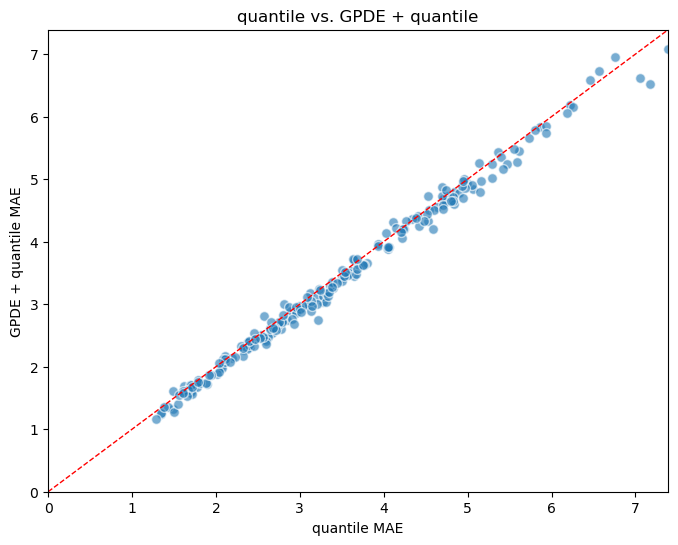

In [14]:
import matplotlib.pyplot as plt

X = quantile_mae_losses
Y = gpde_quantile_mae_losses

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, alpha=0.6, edgecolors='w', s=50)  


max_val = max(max(X), max(Y))  
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", linewidth=1)


plt.xlim(0, max_val)
plt.ylim(0, max_val)

plt.title("quantile vs. GPDE + quantile")
plt.xlabel("quantile MAE")
plt.ylabel("GPDE + quantile MAE")
plt.savefig('outputs/quantile_seperate1.png')

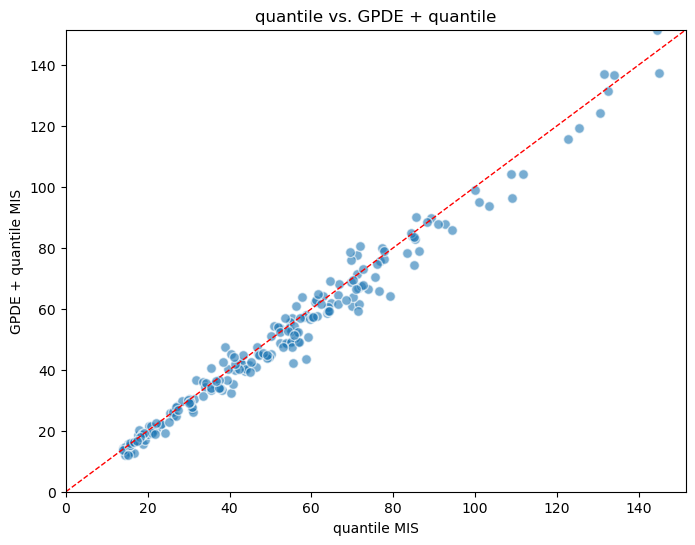

In [15]:
X = quantile_mis_losses
Y = gpde_quantile_mis_losses

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, alpha=0.6, edgecolors='w', s=50)  


max_val = max(max(X), max(Y))  
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", linewidth=1)


plt.xlim(0, max_val)
plt.ylim(0, max_val)


plt.title("quantile vs. GPDE + quantile")
plt.xlabel("quantile MIS")
plt.ylabel("GPDE + quantile MIS")

plt.savefig('outputs/quantile_seperate2.png')

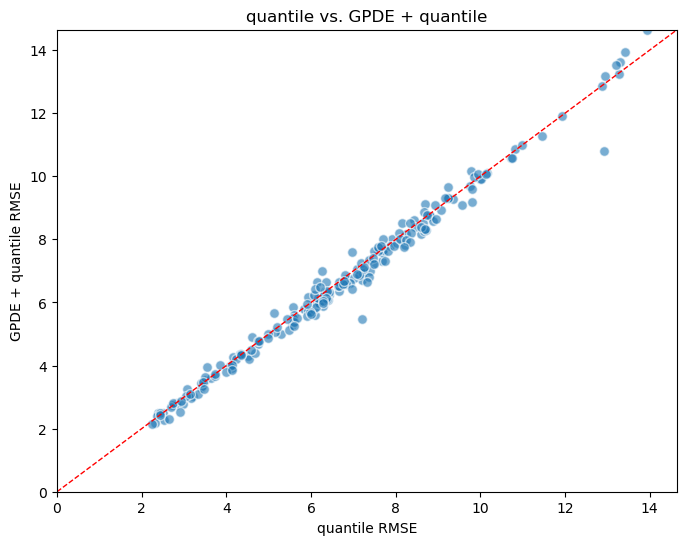

In [16]:
X = quantile_mse_losses
Y = gpde_quantile_mse_losses

X = np.sqrt(quantile_mse_losses)
Y = np.sqrt(gpde_quantile_mse_losses)

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, alpha=0.6, edgecolors='w', s=50)  


max_val = max(max(X), max(Y))  
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", linewidth=1)


plt.xlim(0, max_val)
plt.ylim(0, max_val)


plt.title("quantile vs. GPDE + quantile")
plt.xlabel("quantile RMSE")
plt.ylabel("GPDE + quantile RMSE")

plt.savefig('outputs/quantile_seperate3.png')

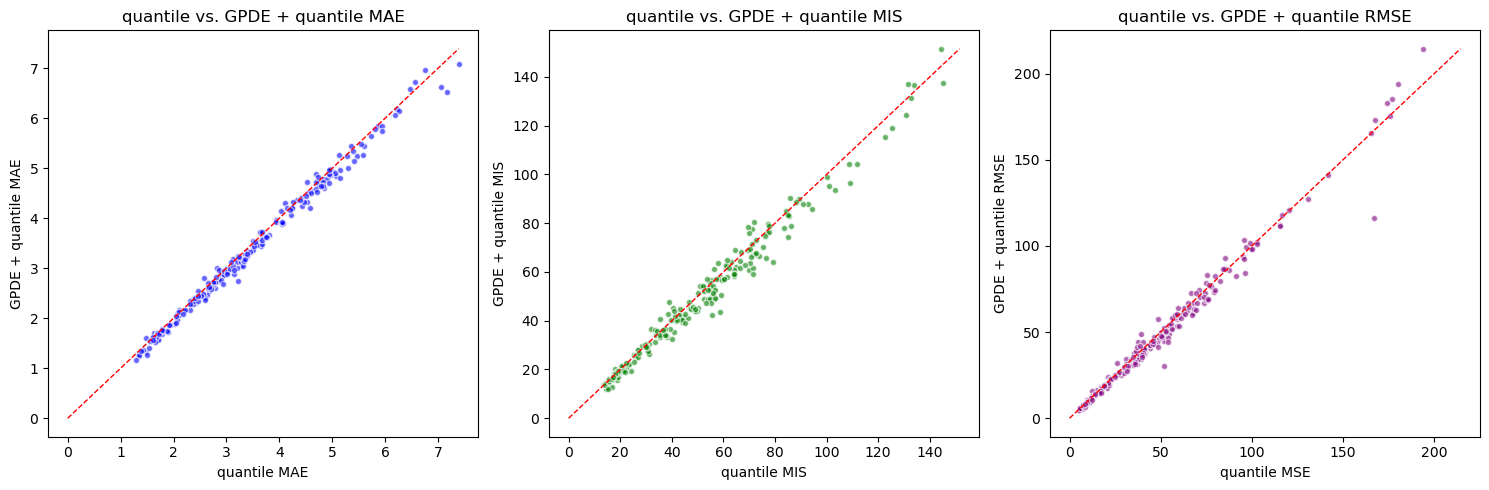

In [17]:
import matplotlib.pyplot as plt
import numpy as np


X1 = quantile_mae_losses
Y1 = gpde_quantile_mae_losses

X2 = quantile_mis_losses
Y2 = gpde_quantile_mis_losses

X3 = quantile_mse_losses
Y3 = gpde_quantile_mse_losses

plt.figure(figsize=(15, 5))  


plt.subplot(1, 3, 1)  
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X1), max(Y1))], [0, max(max(X1), max(Y1))], color="red", linestyle="--", linewidth=1)  
plt.title("quantile vs. GPDE + quantile MAE")
plt.xlabel("quantile MAE")
plt.ylabel("GPDE + quantile MAE")

plt.subplot(1, 3, 2) 
plt.scatter(X2, Y2, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X2), max(Y2))], [0, max(max(X2), max(Y2))], color="red", linestyle="--", linewidth=1) 
plt.title("quantile vs. GPDE + quantile MIS")
plt.xlabel("quantile MIS")
plt.ylabel("GPDE + quantile MIS")

plt.subplot(1, 3, 3) 
plt.scatter(X3, Y3, color="purple", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X3), max(Y3))], [0, max(max(X3), max(Y3))], color="red", linestyle="--", linewidth=1)  
plt.title("quantile vs. GPDE + quantile RMSE")
plt.xlabel("quantile MSE")
plt.ylabel("GPDE + quantile RMSE")

plt.tight_layout()  

plt.savefig('outputs/quantile_seperate4.png')
plt.show()


In [18]:

data_gpde_quantile_phy_model = np.load('data/gpde_quantile_phy_seed0.npz',allow_pickle=True)


predeictions_gpde_quantile_phy = data_gpde_quantile_phy_model['prediction']
truths_gpde_quantile_phy = data_gpde_quantile_phy_model['truth']

#gpde_quantile_model

batch_size = 128
num_batches = predeictions_gpde_quantile_phy.shape[1] // batch_size 

y_pred_batches = predeictions_gpde_quantile_phy.reshape(12, num_batches, batch_size, 207, 3)
y_true_batches = truths_gpde_quantile_phy.reshape(12, num_batches, batch_size, 207)

gpde_quantile_phy_mae_losses = []
gpde_quantile_phy_mse_losses = []
gpde_quantile_phy_mis_losses = []
gpde_quantile_phy_width_losses = []


for j in range(207):
    mae_loss_per_pos = []
    mse_loss_per_pos = []
    mis_loss_per_pos = []
    width_loss_per_pos = []

    for i in range(num_batches):
        y_pred_batch = y_pred_batches[:time_steps, i, :, j,:]
        y_true_batch = y_true_batches[:time_steps, i, :,j]

        mae_loss_batch = masked_mae_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mse_loss_batch = masked_mse_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        mis_loss_batch = mis_loss(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())
        width_batch = width(torch.tensor(y_pred_batch).float(), torch.tensor(y_true_batch).float())

        mae_loss_per_pos.append(mae_loss_batch.item())
        mse_loss_per_pos.append(mse_loss_batch.item())
        mis_loss_per_pos.append(mis_loss_batch.item())
        width_loss_per_pos.append(width_batch.item())

    gpde_quantile_phy_mae_losses.append(sum(mae_loss_per_pos) / len(mae_loss_per_pos))
    gpde_quantile_phy_mse_losses.append(sum(mse_loss_per_pos) / len(mse_loss_per_pos))
    gpde_quantile_phy_mis_losses.append(sum(mis_loss_per_pos) / len(mis_loss_per_pos))
    gpde_quantile_phy_width_losses.append(sum(width_loss_per_pos) / len(width_loss_per_pos))




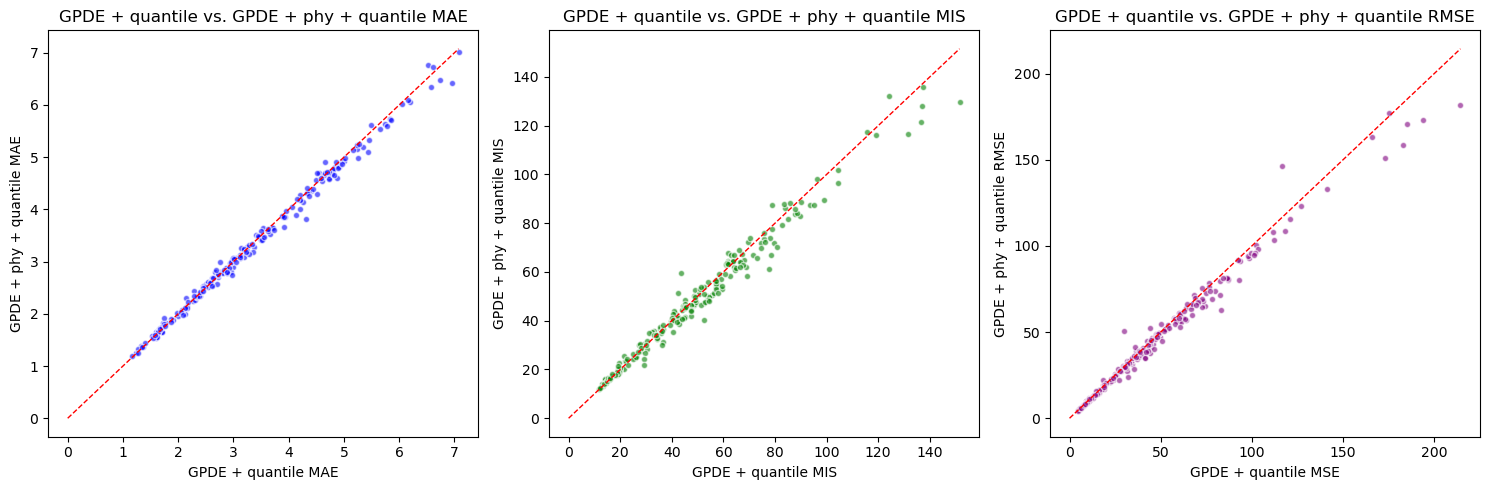

In [19]:
import matplotlib.pyplot as plt
import numpy as np

X1 = gpde_quantile_mae_losses
Y1 = gpde_quantile_phy_mae_losses

X2 = gpde_quantile_mis_losses
Y2 = gpde_quantile_phy_mis_losses

X3 = np.sqrt(gpde_quantile_mse_losses)
Y3 = np.sqrt(gpde_quantile_phy_mse_losses)

X3 = gpde_quantile_mse_losses
Y3 = gpde_quantile_phy_mse_losses

plt.figure(figsize=(15, 5))  


plt.subplot(1, 3, 1)  
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X1), max(Y1))], [0, max(max(X1), max(Y1))], color="red", linestyle="--", linewidth=1)  
plt.title("GPDE + quantile vs. GPDE + phy + quantile MAE")
plt.xlabel("GPDE + quantile MAE")
plt.ylabel("GPDE + phy + quantile MAE")


plt.subplot(1, 3, 2)  
plt.scatter(X2, Y2, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X2), max(Y2))], [0, max(max(X2), max(Y2))], color="red", linestyle="--", linewidth=1) 
plt.title("GPDE + quantile vs. GPDE + phy + quantile MIS")
plt.xlabel("GPDE + quantile MIS")
plt.ylabel("GPDE + phy + quantile MIS")

plt.subplot(1, 3, 3)  
plt.scatter(X3, Y3, color="purple", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X3), max(Y3))], [0, max(max(X3), max(Y3))], color="red", linestyle="--", linewidth=1)  
plt.title("GPDE + quantile vs. GPDE + phy + quantile RMSE")
plt.xlabel("GPDE + quantile MSE")
plt.ylabel("GPDE + phy + quantile RMSE")

plt.tight_layout()  

plt.savefig('outputs/quantile_seperate5.png')
plt.show()


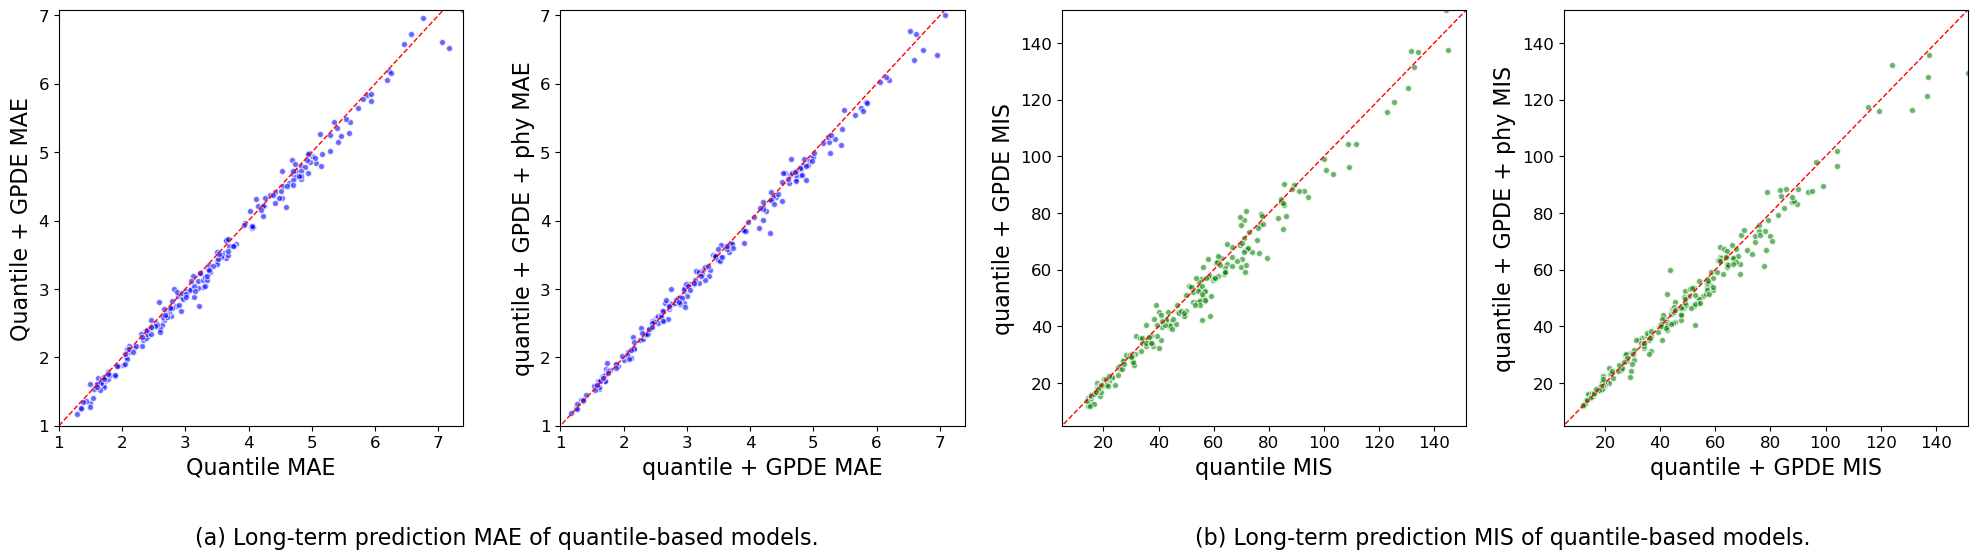

In [20]:
import textwrap
def add_wrapped_text(x, y, text, width, ha='left', fontsize=10):
    wrapped_text = "\n".join(textwrap.wrap(text, width=width))
    plt.figtext(x, y, wrapped_text, ha=ha, fontsize=fontsize)

X1 = quantile_mae_losses
Y1 = gpde_quantile_mae_losses

X2 = gpde_quantile_mae_losses
Y2 = gpde_quantile_phy_mae_losses

X3 = quantile_mis_losses
Y3 = gpde_quantile_mis_losses

X4 = gpde_quantile_mis_losses
Y4 = gpde_quantile_phy_mis_losses

plt.rcParams['axes.labelsize'] = 16  
plt.rcParams['axes.titlesize'] = 16  
plt.rcParams['legend.fontsize'] = 12  
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12  

X1 = np.array(X1)
Y1 = np.array(Y1)
X2 = np.array(X2)
Y2 = np.array(Y2)
X3 = np.array(X3)
Y3 = np.array(Y3)
X4 = np.array(X4)
Y4 = np.array(Y4)


x_min_12 = 1
x_max_12 = max(X1.max(), X2.max())
y_min_12 = 1
y_max_12 = max(Y1.max(), Y2.max())

x_min_34 = 5
x_max_34 = max(X3.max(), X4.max())
y_min_34 = 5
y_max_34 = max(Y3.max(), Y4.max())


plt.figure(figsize=(20, 5))


plt.subplot(1, 4, 1)
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_12, y_max_12)], [0, max(x_max_12, y_max_12)], color="red", linestyle="--", linewidth=1)
plt.xlabel("Quantile MAE")
plt.ylabel("Quantile + GPDE MAE")
plt.xlim(x_min_12, x_max_12)
plt.ylim(y_min_12, y_max_12)

plt.subplot(1, 4, 2)
plt.scatter(X2, Y2, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_12, y_max_12)], [0, max(x_max_12, y_max_12)], color="red", linestyle="--", linewidth=1)
plt.xlabel("quantile + GPDE MAE")
plt.ylabel("quantile + GPDE + phy MAE")
plt.xlim(x_min_12, x_max_12)
plt.ylim(y_min_12, y_max_12)

plt.subplot(1, 4, 3)
plt.scatter(X3, Y3, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_34, y_max_34)], [0, max(x_max_34, y_max_34)], color="red", linestyle="--", linewidth=1)
plt.xlabel("quantile MIS")
plt.ylabel("quantile + GPDE MIS")
plt.xlim(x_min_34, x_max_34)
plt.ylim(y_min_34, y_max_34)

plt.subplot(1, 4, 4)
plt.scatter(X4, Y4, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(x_max_34, y_max_34)], [0, max(x_max_34, y_max_34)], color="red", linestyle="--", linewidth=1)
plt.xlabel("quantile + GPDE MIS")
plt.ylabel("quantile + GPDE + phy MIS")
plt.xlim(x_min_34, x_max_34)
plt.ylim(y_min_34, y_max_34)

add_wrapped_text(0.1, -0.1, "(a) Long-term prediction MAE of quantile-based models. ", width=80, fontsize=16)

add_wrapped_text(0.6, -0.1, "(b) Long-term prediction MIS of quantile-based models. ", width=80, fontsize=16)


plt.tight_layout()

plt.savefig('outputs/quantile_seperate6.png')
plt.show()

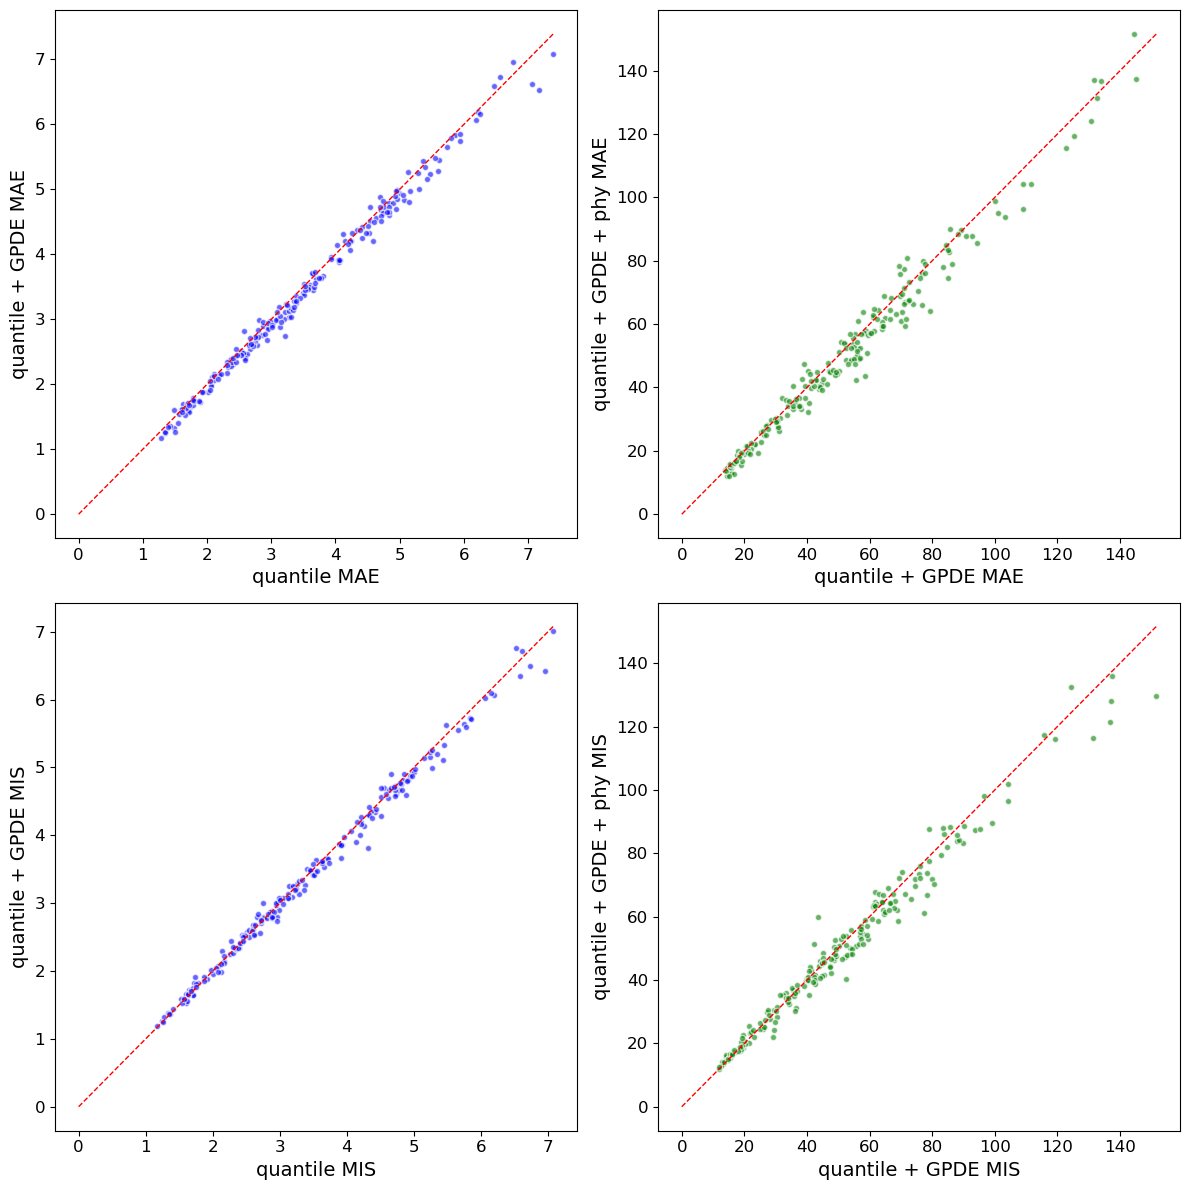

In [21]:

X1 = quantile_mae_losses
Y1 = gpde_quantile_mae_losses

X3 = quantile_mis_losses
Y3 = gpde_quantile_mis_losses

X2 = gpde_quantile_mae_losses
Y2 = gpde_quantile_phy_mae_losses

X4 = gpde_quantile_mis_losses
Y4 = gpde_quantile_phy_mis_losses


plt.figure(figsize=(12, 12))  


plt.subplot(2, 2, 1)  
plt.scatter(X1, Y1, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X1), max(Y1))], [0, max(max(X1), max(Y1))], color="red", linestyle="--", linewidth=1)  # x=y 线
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MAE")
plt.xlabel("quantile MAE",fontsize = 14)
plt.ylabel("quantile + GPDE MAE",fontsize = 14)


plt.subplot(2, 2, 3) 
plt.scatter(X2, Y2, color="blue", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X2), max(Y2))], [0, max(max(X2), max(Y2))], color="red", linestyle="--", linewidth=1)  # x=y 线
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MIS")
plt.xlabel("quantile MIS",fontsize = 14)
plt.ylabel("quantile + GPDE MIS",fontsize = 14)


plt.subplot(2, 2, 2) 
plt.scatter(X3, Y3, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X3), max(Y3))], [0, max(max(X3), max(Y3))], color="red", linestyle="--", linewidth=1)  # x=y 线
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MAE")
plt.xlabel("quantile + GPDE MAE",fontsize = 14)
plt.ylabel("quantile + GPDE + phy MAE",fontsize = 14)

plt.subplot(2, 2, 4)  
plt.scatter(X4, Y4, color="green", alpha=0.6, edgecolors="w", s=20)
plt.plot([0, max(max(X4), max(Y4))], [0, max(max(X4), max(Y4))], color="red", linestyle="--", linewidth=1)  # x=y 线
#plt.title("GPDE + quantile vs. GPDE + phy + quantile MIS")
plt.xlabel("quantile + GPDE MIS",fontsize = 14)
plt.ylabel("quantile + GPDE + phy MIS",fontsize = 14)

plt.tight_layout()  

plt.savefig('outputs/quantile_seperate7.png')
plt.show()



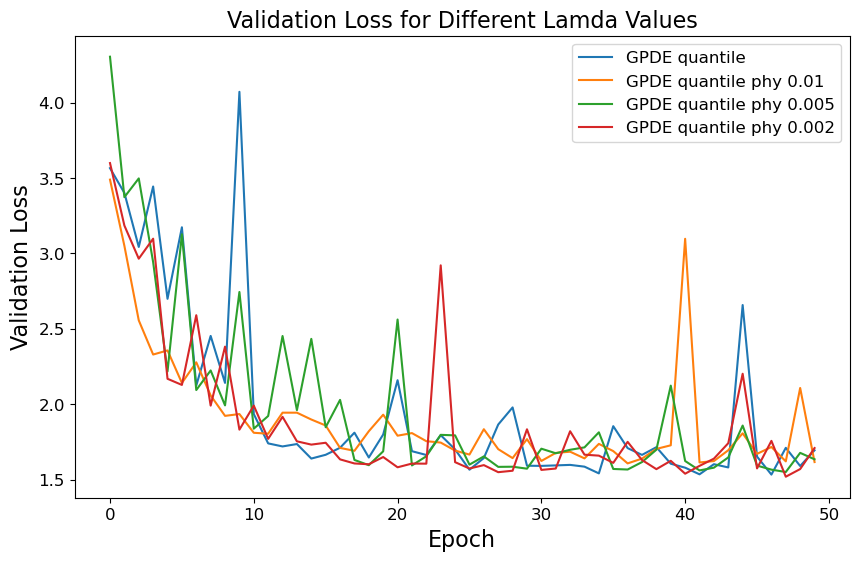

In [22]:
import matplotlib.pyplot as plt


plt.rcParams['axes.labelsize'] = 16  
plt.rcParams['axes.titlesize'] = 16  
plt.rcParams['legend.fontsize'] = 12  
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12  

val_mae_values_quantile = [
    3.5651, 3.4011, 3.043, 3.4436, 2.6993, 3.1732, 2.1242, 2.4533, 2.142, 4.0709,
    1.9354, 1.7411, 1.721, 1.7369, 1.6406, 1.6657, 1.7122, 1.8121, 1.6476, 1.8001,
    2.1599, 1.6894, 1.6644, 1.7959, 1.7014, 1.5669, 1.6443, 1.8662, 1.9796, 1.5932,
    1.5921, 1.5953, 1.5987, 1.587, 1.5424, 1.8553, 1.7098, 1.6649, 1.716, 1.6065,
    1.5802, 1.5362, 1.6032, 1.5819, 2.6581, 1.6537, 1.5344, 1.7117, 1.5914, 1.6955
]

val_mae_values_quantile_phy_001 = [
    3.489, 3.0503, 2.5565, 2.33, 2.3572, 2.1417, 2.2785, 2.0589, 1.9236, 1.9356,
    1.8115, 1.8053, 1.9447, 1.9447, 1.8994, 1.8598, 1.7113, 1.6919, 1.8218, 1.9315,
    1.7922, 1.8094, 1.7558, 1.7466, 1.6935, 1.6671, 1.8351, 1.703, 1.6436, 1.7693,
    1.6248, 1.678, 1.6861, 1.6418, 1.738, 1.6901, 1.6086, 1.6404, 1.7047, 1.7285,
    3.097, 1.6148, 1.6241, 1.6959, 1.808, 1.6718, 1.7173, 1.6221, 2.1085, 1.6175
]

val_mae_values_quantile_phy_0005 = [
    4.3035, 3.373, 3.4971, 2.9423, 2.2178, 3.127, 2.0948, 2.2245, 1.993, 2.7445,
    1.8387, 1.9227, 2.4529, 1.9613, 2.4339, 1.8484, 2.0295, 1.6315, 1.5968, 1.6887,
    2.562, 1.5952, 1.6558, 1.7978, 1.7943, 1.6005, 1.655, 1.5856, 1.5866, 1.5736,
    1.7061, 1.6757, 1.6988, 1.7148, 1.8145, 1.5717, 1.568, 1.6174, 1.6993, 2.124,
    1.6244, 1.5621, 1.5803, 1.6482, 1.8593, 1.5941, 1.5673, 1.5515, 1.6784, 1.6358
]
val_mae_values_quantile_phy_0002 = [
    3.5988, 3.1848, 2.9651, 3.0977, 2.1693, 2.1286, 2.5907, 1.9914, 2.3824, 1.8324,
    1.9916, 1.7712, 1.9171, 1.7548, 1.7331, 1.7454, 1.6353, 1.6082, 1.6028, 1.6508,
    1.5828, 1.6075, 1.6068, 2.9211, 1.6168, 1.5747, 1.5972, 1.5504, 1.56, 1.8346,
    1.5654, 1.5746, 1.8217, 1.6664, 1.66, 1.612, 1.7514, 1.631, 1.5705, 1.6257,
    1.5403, 1.5922, 1.64, 1.7426, 2.2028, 1.5755, 1.7579, 1.5203, 1.5711, 1.7103
]

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(val_mae_values_quantile, label="GPDE quantile")
plt.plot(val_mae_values_quantile_phy_001, label="GPDE quantile phy 0.01")
plt.plot(val_mae_values_quantile_phy_0005, label="GPDE quantile phy 0.005")
plt.plot(val_mae_values_quantile_phy_0002, label="GPDE quantile phy 0.002")

# Adding labels and legend
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Different Lamda Values")
plt.legend()
#plt.grid(True)

plt.savefig('outputs/quantile_seperate8.png')
plt.show()

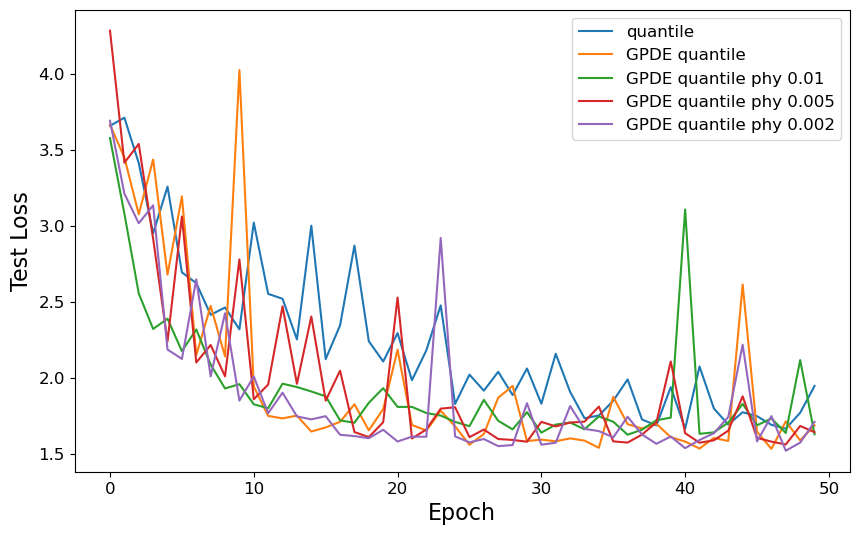

In [23]:
import matplotlib.pyplot as plt
test_mae_quantile = [3.6593, 3.7128, 3.4139, 2.9518, 3.259, 2.6948, 2.6242, 2.4154, 2.4637, 2.3201,
 3.0219, 2.5533, 2.521, 2.2536, 3.0023, 2.1242, 2.3458, 2.8712, 2.2416, 2.1083,
 2.295, 1.9854, 2.1815, 2.4777, 1.8288, 2.0218, 1.9163, 2.0406, 1.8875, 2.0623,
 1.8303, 2.159, 1.9088, 1.7349, 1.7527, 1.8499, 1.9902, 1.7269, 1.6876, 1.9394,
 1.6658, 2.0754, 1.799, 1.6932, 1.7745, 1.7484, 1.6916, 1.6663, 1.771, 1.9472]

test_mae_quantile_gpde = [3.6666, 3.4508, 3.0772, 3.4374, 2.6801, 3.1949, 2.1507, 2.4743, 2.1418, 4.0261,
 1.9435, 1.75, 1.734, 1.752, 1.6474, 1.6746, 1.711, 1.8267, 1.6556, 1.7945,
 2.1856, 1.6904, 1.6539, 1.7843, 1.6816, 1.5603, 1.6313, 1.8698, 1.9475, 1.5847,
 1.5941, 1.5833, 1.6022, 1.5877, 1.5402, 1.8754, 1.6958, 1.6675, 1.6984, 1.6102,
 1.5813, 1.5355, 1.605, 1.5852, 2.6147, 1.6458, 1.5336, 1.7141, 1.5892, 1.6877]

test_mae_quantile_phy_001 = [3.5784, 3.0814, 2.556, 2.3223, 2.3899, 2.1767, 2.3192, 2.0879, 1.9307, 1.9592,
 1.8265, 1.8005, 1.9622, 1.9402, 1.911, 1.8792, 1.7207, 1.7053, 1.8365, 1.9328,
 1.8094, 1.8097, 1.7693, 1.7526, 1.7111, 1.6825, 1.8558, 1.7181, 1.6617, 1.7745,
 1.64, 1.6931, 1.7067, 1.662, 1.7468, 1.7117, 1.6265, 1.6598, 1.7216, 1.7389,
 3.1085, 1.6324, 1.6418, 1.7062, 1.8292, 1.6885, 1.7335, 1.638, 2.1177, 1.6294]

test_mae_quantile_phy_0005 = [4.2851, 3.4163, 3.54, 2.9156, 2.2405, 3.0623, 2.1017, 2.2169, 2.0106, 2.78,
 1.8594, 1.9569, 2.4714, 1.961, 2.4042, 1.851, 2.0479, 1.644, 1.6107, 1.7086,
 2.5294, 1.6018, 1.6609, 1.7979, 1.8073, 1.6106, 1.6603, 1.5981, 1.592, 1.5805,
 1.7109, 1.6811, 1.7064, 1.7121, 1.8116, 1.5825, 1.5748, 1.6276, 1.7071, 2.1084,
 1.6365, 1.5737, 1.5897, 1.6531, 1.8789, 1.6056, 1.5809, 1.562, 1.684, 1.6433]

test_mae_quantile_phy_0002 = [3.6926, 3.213, 3.018, 3.1363, 2.1872, 2.1251, 2.6489, 2.0104, 2.4261, 1.851,
 2.0095, 1.7679, 1.903, 1.7468, 1.7274, 1.7484, 1.626, 1.6173, 1.6036, 1.659,
 1.5816, 1.6137, 1.6131, 2.9212, 1.6151, 1.5762, 1.5982, 1.5515, 1.5581, 1.834,
 1.5607, 1.5738, 1.815, 1.665, 1.6502, 1.6091, 1.7446, 1.628, 1.5668, 1.6145,
 1.538, 1.5915, 1.6364, 1.7429, 2.219, 1.5825, 1.7489, 1.5211, 1.5744, 1.7107]

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(test_mae_quantile, label="quantile")
plt.plot(test_mae_quantile_gpde, label="GPDE quantile")
plt.plot(test_mae_quantile_phy_001, label="GPDE quantile phy 0.01")
plt.plot(test_mae_quantile_phy_0005, label="GPDE quantile phy 0.005")
plt.plot(test_mae_quantile_phy_0002, label="GPDE quantile phy 0.002")

# Adding labels and legend
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
#plt.title("Test Loss for Different Lamda Values")
plt.legend()
#plt.grid(True)
plt.show()

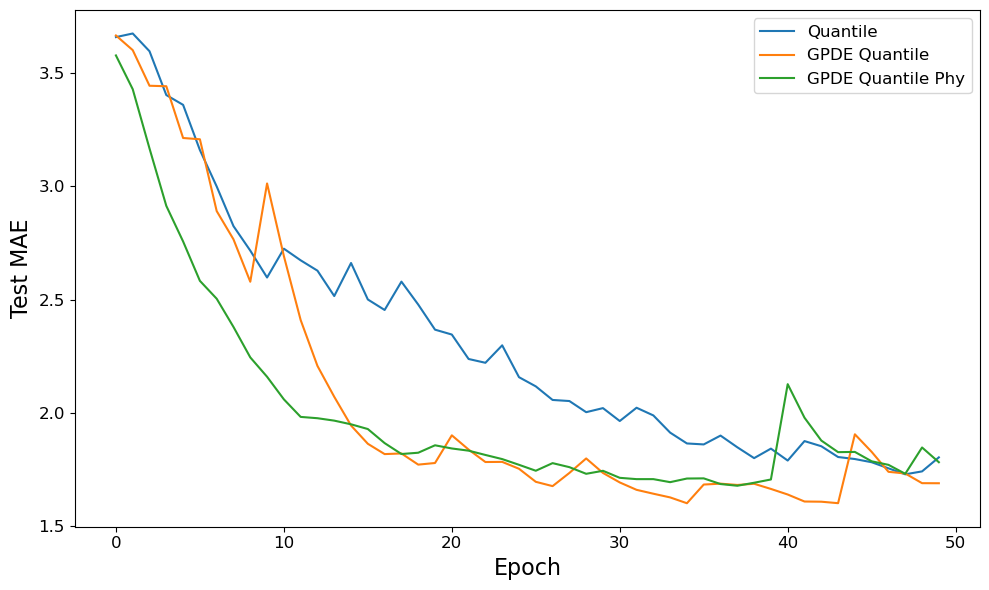

In [24]:

plt.rcParams['axes.labelsize'] = 16  
plt.rcParams['axes.titlesize'] = 16  
plt.rcParams['legend.fontsize'] = 12  
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12  
def exponential_moving_average(data, alpha=0.3):
    smoothed_data = [data[0]]  
    for i in range(1, len(data)):
        smoothed_data.append(alpha * data[i] + (1 - alpha) * smoothed_data[i-1])
    return smoothed_data


smooth_test_mae_quantile = exponential_moving_average(test_mae_quantile)
smooth_test_mae_quantile_gpde = exponential_moving_average(test_mae_quantile_gpde)
smooth_test_mae_quantile_phy_001 = exponential_moving_average(test_mae_quantile_phy_001)
smooth_test_mae_quantile_phy_0005 = exponential_moving_average(test_mae_quantile_phy_0005)
smooth_test_mae_quantile_phy_0002 = exponential_moving_average(test_mae_quantile_phy_0002)


plt.figure(figsize=(10, 6))
plt.plot(smooth_test_mae_quantile, label="Quantile")
plt.plot(smooth_test_mae_quantile_gpde, label="GPDE Quantile")
plt.plot(smooth_test_mae_quantile_phy_001, label="GPDE Quantile Phy")
#plt.plot(smooth_test_mae_quantile_phy_0005, label="GPDE quantile phy 0.005")
#plt.plot(smooth_test_mae_quantile_phy_0002, label="GPDE quantile phy 0.002")

plt.xlabel("Epoch")
plt.ylabel("Test MAE")
plt.legend()
plt.tight_layout()
plt.show()


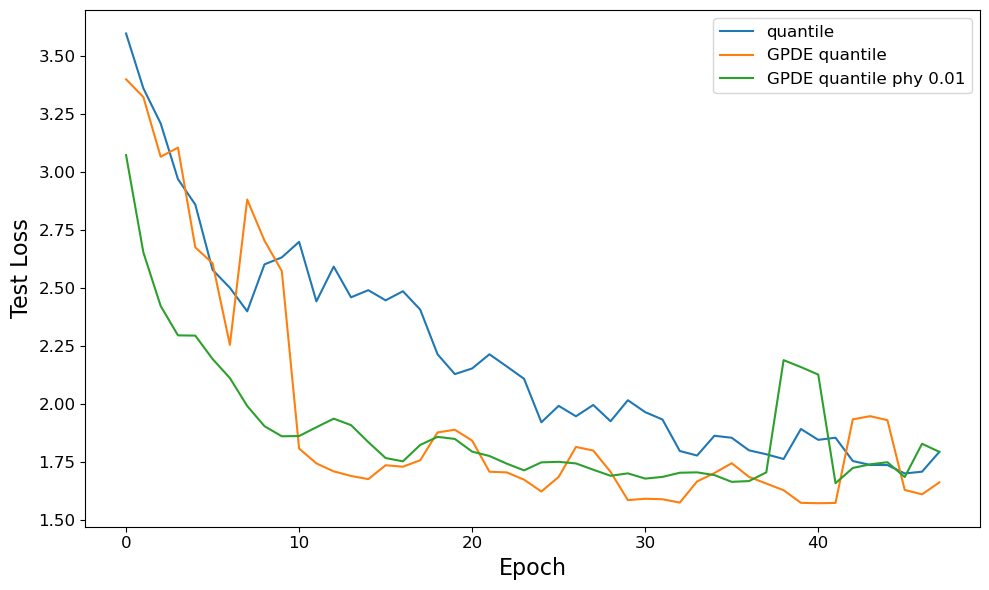

In [25]:
import numpy as np

def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


smooth_test_mae_quantile = moving_average(test_mae_quantile, window_size=3)
smooth_test_mae_quantile_gpde = moving_average(test_mae_quantile_gpde, window_size=3)
smooth_test_mae_quantile_phy_001 = moving_average(test_mae_quantile_phy_001, window_size=3)
smooth_test_mae_quantile_phy_0005 = moving_average(test_mae_quantile_phy_0005, window_size=3)
smooth_test_mae_quantile_phy_0002 = moving_average(test_mae_quantile_phy_0002, window_size=3)

plt.figure(figsize=(10, 6))
plt.plot(smooth_test_mae_quantile, label="quantile")
plt.plot(smooth_test_mae_quantile_gpde, label="GPDE quantile")
plt.plot(smooth_test_mae_quantile_phy_001, label="GPDE quantile phy 0.01")
#plt.plot(smooth_test_mae_quantile_phy_0005, label="GPDE quantile phy 0.005")
#plt.plot(smooth_test_mae_quantile_phy_0002, label="GPDE quantile phy 0.002")

plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.legend()
plt.tight_layout()
plt.show()


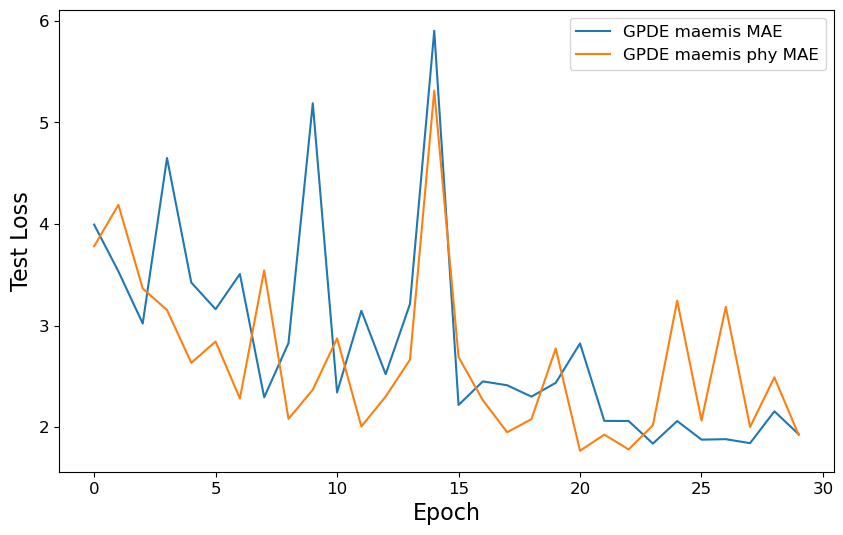

In [26]:
gpde_maemis_pemsd8 = ([3.9929, 3.5324, 3.0199, 4.6483, 3.4228, 3.1606, 3.5069, 2.294,
       2.8272, 5.1872, 2.3415, 3.1453, 2.5207, 3.2114, 5.9006, 2.2181,
       2.4504, 2.4124, 2.3005, 2.4363, 2.8242, 2.0616, 2.0607, 1.8386,
       2.0605, 1.8774, 1.882 , 1.8425, 2.156 , 1.9307])


gpde_maemis_phy_pemsd8 = ([3.7803, 4.1871, 3.3644, 3.152 , 2.6332, 2.8426, 2.2823, 3.543 ,
       2.0814, 2.3687, 2.8738, 2.0064, 2.3016, 2.6637, 5.3118, 2.6894,
       2.2652, 1.95  , 2.079 , 2.7738, 1.7683, 1.9265, 1.781 , 2.0182,
       3.2448, 2.0653, 3.1834, 2.0019, 2.4904, 1.9239])

plt.figure(figsize=(10, 6))
plt.plot(gpde_maemis_pemsd8, label="GPDE maemis MAE")
plt.plot(gpde_maemis_phy_pemsd8, label="GPDE maemis phy MAE")
#plt.plot(test_mae_quantile_phy_001, label="GPDE quantile phy 0.01")
#plt.plot(test_mae_quantile_phy_0005, label="GPDE quantile phy 0.005")
#plt.plot(test_mae_quantile_phy_0002, label="GPDE quantile phy 0.002")

# Adding labels and legend
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
#plt.title("Test Loss for Different Lamda Values")
plt.legend()
#plt.grid(True)
plt.show()